In [239]:
%reload_ext autoreload
%autoreload 2
# imports
import os
import ast
import math
import json
import requests
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import ipywidgets as widgets

import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


from scipy import stats
from datetime import datetime as dt
from ipywidgets import interact, interactive, fixed, interact_manual

from IPython.display import HTML
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [240]:
import helpers


movies,characters = helpers.import_movies_data("./data")


/Users/antoineschutz/Documents/GitHub/ada-2023-project-zalix/helpers.py:73: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  movies["year_released"] = pd.to_datetime(


# Leading Actors Impact on Movies Ratings
- This section investigate the impact of the cast on Movie ratings
- It will also look at the evolution of ratings for actors

## Data Preprocessing 

In [241]:
print(movies.isna().sum())

print(characters.isna().sum())

wikipedia_movie_ID              0
freebase_movie_ID               0
movie_name                      0
movie_release_date              0
movie_box_office_revenue    11289
movie_runtime                 760
movie_languages                 0
movie_countries                 0
movie_genres                    0
year_released                   0
tconst                          0
averageRating                   0
numVotes                        0
dtype: int64
wikipedia_movie_ID                      0
freebase_movie_ID                       0
last_update                          9995
character_name                     257875
actor_DOB                          106145
actor_gender                        45609
actor_height                       295845
actor_ethnicity                    344611
actor_name                           1228
actor_age_at_movie_release         158113
freebase_character/actor_map_ID         0
freebase_character_ID              257865
freebase_actor_ID                     815

We need actors to be identifiable , so we have to drop rows without freebase_actor_ID  

In [242]:
characters = characters[characters["freebase_actor_ID"].notna()]


In [243]:
Movies_characters_merge = pd.merge(movies,characters,on=["wikipedia_movie_ID", "freebase_movie_ID"])


Movies_characters_merge.head(5)



,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year_released,...,character_name,actor_DOB,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_character/actor_map_ID,freebase_character_ID,freebase_actor_ID
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,...,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,...,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,...,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,...,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,...,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


Now , we need to make sure that an actor appears only once in a Movie

In [244]:
dup = Movies_characters_merge[Movies_characters_merge.duplicated(subset=["wikipedia_movie_ID","freebase_actor_ID"],keep=False)]
dup.head(5)

,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year_released,...,character_name,actor_DOB,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_character/actor_map_ID,freebase_character_ID,freebase_actor_ID
45,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",1964,...,Bert,1925-12-13,M,1.85,/m/07mqps,Dick Van Dyke,38.0,/m/0k0gyy,/m/05gkznp,/m/01vb403
47,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",1964,...,Mr. Dawes Senior,1925-12-13,M,1.85,/m/07mqps,Dick Van Dyke,38.0,/m/0h12l69,/m/0h12l6c,/m/01vb403
534,6004372,/m/0fk60h,Grace of My Heart,1996-09-08,617632.0,116.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/09glv8x"": ""Film \u00e0 clef"", ""/m/04xvlr""...",1996,...,Denise Waverly,1965-07-25,F,1.74,NaN,Illeana Douglas,31.0,/m/0jyzlg,/m/0h5m7zm,/m/01pg1d
535,6004372,/m/0fk60h,Grace of My Heart,1996-09-08,617632.0,116.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/09glv8x"": ""Film \u00e0 clef"", ""/m/04xvlr""...",1996,...,Edna Buxton,1965-07-25,F,1.74,NaN,Illeana Douglas,31.0,/m/0hmzb_v,/m/0hmzb_y,/m/01pg1d
735,20694087,/m/051w_vb,Kanden Kadhalai,2009-10-30,NaN,NaN,"{""/m/07c9s"": ""Tamil Language""}","{""/m/03rk0"": ""India""}","{""/m/02l7c8"": ""Romance Film"", ""/m/01z4y"": ""Com...",2009,...,Mayil Vaganam,1953-06-04,M,NaN,/m/0dryh9k,Manobala,56.0,/m/0hb4c_j,/m/0hb4czd,/m/06zmg7m


Exemple : In the movie Mary poppins the actor Dick Van Dyke plays Bert and Mr. Dawes Senior	

In [245]:
Movies_characters_merge = Movies_characters_merge.drop_duplicates(subset=["wikipedia_movie_ID","freebase_actor_ID"])
print("We have",Movies_characters_merge.shape[0],"Combinations of Movies+actor")

We have 105389 Combinations of Movies+actor


In [246]:
unique_movies = len(Movies_characters_merge["freebase_movie_ID"].unique())
unique_actors = len(Movies_characters_merge["freebase_actor_ID"].unique())


print("There are",unique_movies,"unique movies and",unique_actors,"unique actors")



There are 12570 unique movies and 46250 unique actors


### Numbers of Actors in movies , and Number of Movies played by actors

count    46250.000000
mean         2.278681
std          3.261078
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        100.000000
Name: Number_of_Movies, dtype: float64
1.0


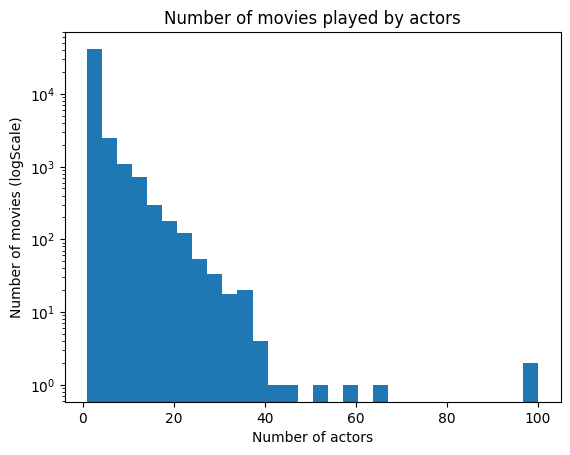

In [247]:
import matplotlib.pyplot as plt

actor_movies_count = Movies_characters_merge.groupby("freebase_actor_ID")["freebase_movie_ID"].nunique().reset_index()
actor_movies_count.columns = ['Actor_id', 'Number_of_Movies']



print(actor_movies_count['Number_of_Movies'].describe())

print(actor_movies_count['Number_of_Movies'].quantile(0.65))


plt.hist(actor_movies_count['Number_of_Movies'],bins=30,log=True)
plt.title("Number of movies played by actors")
plt.xlabel("Number of actors")
plt.ylabel("Number of movies (logScale)")
plt.show()

### Comment

We can see that most actors in the dataset played in only 1 Movies.

In order to do our analysis , we need to keep actors that played in multiple Movies.

count    12570.000000
mean         8.384169
std          6.080858
min          1.000000
25%          3.000000
50%          8.000000
75%         12.000000
max        115.000000
Name: Number_of_actors, dtype: float64


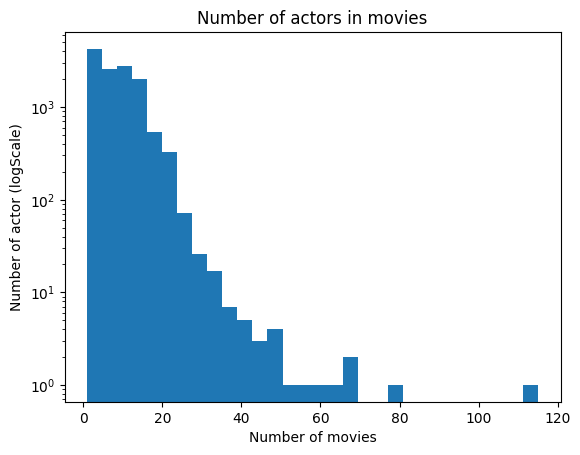

In [248]:
movies_actor_count = Movies_characters_merge.groupby("freebase_movie_ID")["freebase_actor_ID"].nunique().reset_index()
movies_actor_count.columns = ['Movies_id', 'Number_of_actors']



print(movies_actor_count['Number_of_actors'].describe())




plt.hist(movies_actor_count['Number_of_actors'],bins=30,log=True)
plt.title("Number of actors in movies")
plt.xlabel("Number of movies")
plt.ylabel("Number of actor (logScale)")
plt.show()

### Comment

We see that there are 8 actors on average on a Movie.

# Filtering Actors with Not enough Films

In [249]:
actors_with_at_least_10_movies = actor_movies_count[actor_movies_count.Number_of_Movies>10]
actors_with_at_least_20_movies = actor_movies_count[actor_movies_count.Number_of_Movies>20]



print("There are ",actors_with_at_least_10_movies.shape[0],"actors with at least 10 films, and ",actors_with_at_least_20_movies.shape[0],"actors with at least 20 films")



Movies_characters_merge_10movies = Movies_characters_merge[Movies_characters_merge["freebase_actor_ID"].isin(actors_with_at_least_10_movies.Actor_id.values)]
Movies_characters_merge_20movies = Movies_characters_merge[Movies_characters_merge["freebase_actor_ID"].isin(actors_with_at_least_20_movies.Actor_id.values)]




#Sanity check : 
unique_actors_10 = len(Movies_characters_merge_10movies["freebase_actor_ID"].unique())
unique_actors_20 = len(Movies_characters_merge_20movies["freebase_actor_ID"].unique())
unique_actors_10,unique_actors_20

There are  1450 actors with at least 10 films, and  260 actors with at least 20 films


(1450, 260)

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     11.05
Date:                Fri, 17 Nov 2023   Prob (F-statistic):           0.000890
Time:                        15:47:47   Log-Likelihood:                -9012.7
No. Observations:                7014   AIC:                         1.803e+04
Df Residuals:                    7012   BIC:                         1.804e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         8.7147      0.705     12.369

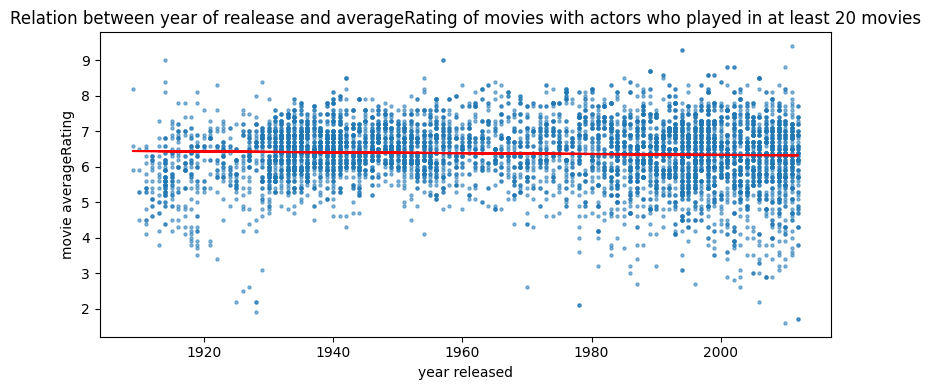

In [250]:
#perform linear regression on duration data, and plot the regression line
model=smf.ols(formula='averageRating ~ year_released', data=Movies_characters_merge_20movies)
results=model.fit()
print(results.summary())

plt.figure(figsize=(8, 4))
plt.scatter(Movies_characters_merge_20movies["year_released"], Movies_characters_merge_20movies["averageRating"], alpha=0.5, s=5)

plt.plot(Movies_characters_merge_20movies["year_released"], results.predict(), color="red")
plt.title("Relation between year of realease and averageRating of movies with actors who played in at least 20 movies")
plt.xlabel("year released")
plt.ylabel("movie averageRating")

plt.tight_layout()


plt.show()

# Visualisation of the Evolution of ratings for 5 random actors

In [251]:
import random


actorsId_20movies = Movies_characters_merge_20movies["freebase_actor_ID"].tolist() #List all actors that played in at least 20 movies
selected_actors = random.sample(actorsId_20movies, k=5) #Select 5 actors out of that list


Movies_characters_selected = Movies_characters_merge_20movies[Movies_characters_merge_20movies["freebase_actor_ID"].isin(selected_actors)] #


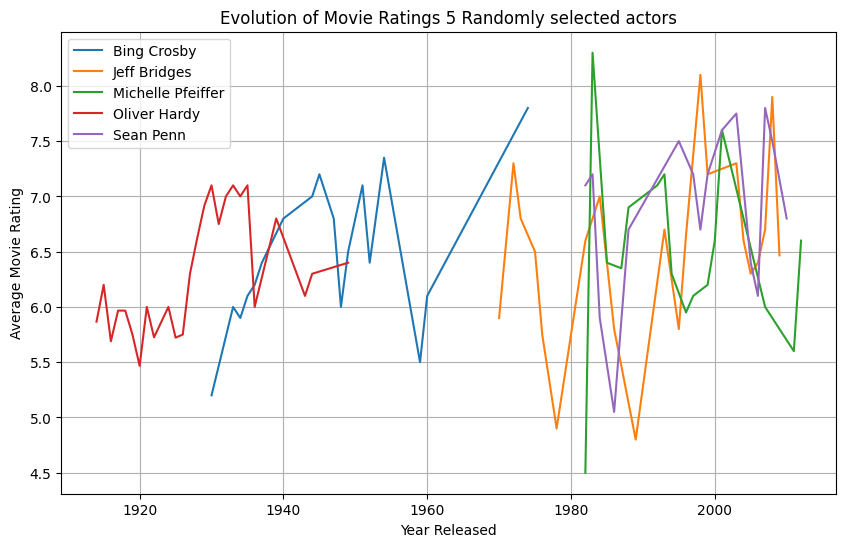

In [252]:
average_ratings_by_actor_year = Movies_characters_selected.groupby(['freebase_actor_ID','actor_name', 'year_released'])['averageRating'].mean().reset_index()

# Plotting the evolution of movie ratings across the years for all actors
plt.figure(figsize=(10, 6))

# Iterate through each actor, calculate their ratings over the years, and plot
for actor_id, actor_group in average_ratings_by_actor_year.groupby(['freebase_actor_ID',"actor_name"]):
    plt.plot(actor_group['year_released'], actor_group['averageRating'], label=actor_id[1])

# Set plot labels and title
plt.xlabel('Year Released')
plt.ylabel('Average Movie Rating')
plt.title('Evolution of Movie Ratings 5 Randomly selected actors')
plt.legend()  # Show legend with actor IDs

# Show the plot
plt.grid(True)
plt.show()

## Relation between year of realease and averageRating for actors with at least 20 movies

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.006
Date:                Fri, 17 Nov 2023   Prob (F-statistic):             0.0842
Time:                        15:47:47   Log-Likelihood:                -63.412
No. Observations:                 260   AIC:                             130.8
Df Residuals:                     258   BIC:                             137.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 8.85

Text(0, 0.5, 'movie averageRating')

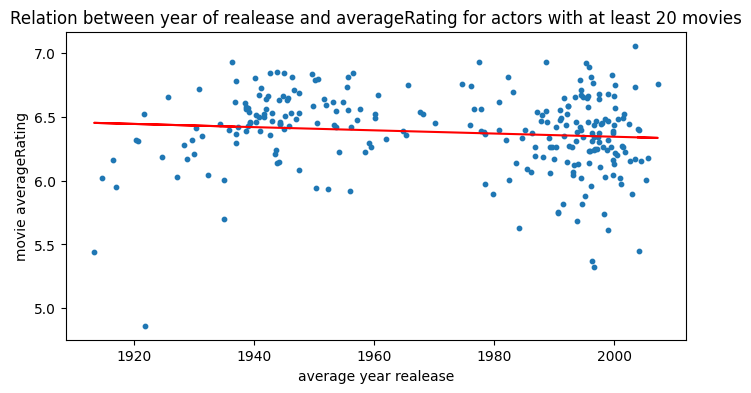

In [253]:
best_actors = Movies_characters_merge_20movies.groupby(["freebase_actor_ID","actor_name"]).agg({
    'averageRating': 'mean',
    'year_released': 'mean'
}).reset_index()

best_actors.sort_values(by="averageRating",ascending=False)

best_actors.columns=["freebase_actor_ID","actor_name","averageRating","average_year_realease"]

model=smf.ols(formula='averageRating ~ average_year_realease', data=best_actors)
results=model.fit()
print(results.summary())

plt.figure(figsize=(8, 4))
plt.scatter(best_actors["average_year_realease"], best_actors["averageRating"],s=10)

plt.plot(best_actors["average_year_realease"], results.predict(), color="red")
plt.title("Relation between year of realease and averageRating for actors with at least 20 movies")
plt.xlabel("average year realease")
plt.ylabel("movie averageRating")